# Predicting ground state of molecule using Hybrid quantum-classical Neural Networks(FFNN) (please run all before look at it, I dont have time to train)
## Project Description - poig
I am a highschool student, unable find any free team so decide to solo it. This is my first AI project, without much knowledgth about AI.  
I dont have credit card, cant use aws power up redeem code.

my linkedin - linkedin.com/in/jun-liang-tan-0b8b53133/
### goal:
predict the ground state energies of molecules using Coulomb matrices as input using quantum-classical Neural Networks. I hope to combine advanced feed forward neural network(FFNN) and quantum neural network(QNN) to achieve higher accuracy.


It will train over 16,242 Molecules ground state with FNN&QNN.
[training databset from kaggle](https://www.kaggle.com/burakhmmtgl/energy-molecule/code)

### reference (those I think is important)- 
[1] [Predicting excited states from ground state wavefunction by supervised quantum machine learning Hiroki Kawai, Yuya O. Nakagawa](https://www.arxiv.org/pdf/2002.12925.pdf) (where my idea come from)   
[2] [Tree based machine learning framework for predicting ground state energies of molecules](https://www.arxiv.org/pdf/1609.07124.pdf)  (where the data set from, can download from kaggle)  
[3] [qiskit- hybrid neural network](https://www.qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html) (where I get idea how to do it)   
[4] [pennylane- recurrent neural network lstm](https://www.pennylane.ai/qml/demos/learning2learn.html#recurrent-neural-network-lstm) (where I get idea of####)  
[5] [github- AdvancedNNfromScratch](https://www.github.com/mukul-rathi/ChemRegressionNeuralNet/blob/master/AdvancedNNfromScratch.ipynb) (where I understand step need for this project)  
[6] [Can One Hear the Shape of a Molecule (from its Coulomb Matrix Eigenvalues)? Joshua Schrier Journal of Chemical Information and Modeling 2020 60 (8), 3804-3811 DOI: 10.1021/acs.jcim.0c00631](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00631) (where I understand little about coulomb matrix, how much thing can do with it)  
[7] cheminformania.com/building-a-simple-qsar-model-using-a-feed-forward-neural-network-in-pytorch/

# Project
## Contents

1. [setup data](#setup-data)
2. [hyperparameter](#hyper-parameter-that-can-tune-to-improve-traning)
3.  
4. 

In [2]:
import qiskit
from qiskit import QuantumCircuit, transpile, Aer ,  execute, BasicAer, assemble
from qiskit.visualization import *
from qiskit_machine_learning import *
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult
from qiskit.providers.aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import ParameterVector
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

import torch
from torch.autograd import Function
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as u
from torch.utils.data import TensorDataset

import pennylane as qml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import networkx as nx
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import sys
#import sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## setup data<a id="data"></a>
### Data set - kaggle.com/burakhmmtgl/energy-molecule

In [3]:
dataset = pd.read_csv('roboBohr.csv') #create a new dataframe containing the input data
dataset.Eat.describe()

count    16242.000000
mean       -11.178969
std          3.659133
min        -23.245373
25%        -13.475805
50%        -10.835211
75%         -8.623903
max         -0.789513
Name: Eat, dtype: float64

In [4]:
dataset.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


### split- train set, validation, test

In [5]:
df = dataset.drop(['Unnamed: 0','pubchem_id'],axis=1)
X = df.drop(['Eat'], axis = 1).values
y = df['Eat'].values.reshape((-1,1))
print("X shape: ",X.shape)
print("Y shape: ",y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
print("X Y train,test shape: ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("X Y train,validation shape: ",X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

X shape:  (16242, 1275)
Y shape:  (16242, 1)
X Y train,test shape:  (13886, 1275) (1625, 1275) (13886, 1) (1625, 1)
X Y train,validation shape:  (13886, 1275) (731, 1275) (13886, 1) (731, 1)


In [6]:
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(13886, 471)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If you don't have a GPU, buy a graphics card. I have for a long time used a 1060 GTX, which is not that expensive anymore.
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_test

cpu


tensor([[ 73.5167,  20.6862,  18.5772,  ...,   0.0000,   0.0000,   0.0000],
        [ 73.5167,  20.5861,  16.4353,  ...,   0.5000,   0.5000,   0.0000],
        [ 73.5167,  20.7930,  18.6475,  ...,   0.5000,   0.5000,   0.5000],
        ...,
        [332.3449,  42.7018,  39.4562,  ...,   0.0000,   0.0000,   0.0000],
        [ 53.3587,  17.1402,  16.1576,  ...,   0.0000,   0.0000,   0.0000],
        [ 73.5167,  18.5443,  17.8277,  ...,   0.5000,   0.5000,   0.5000]])

In [8]:
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=256,
                                              shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                  batch_size=256,
                                                  shuffle=False)

## create neural network
### hyper-parameter that can tune to improve traning

In [9]:
#can be easy tune when train
hyperparameters={}
hyperparameters["num_epochs"] = 20 #number of passes through the training set
hyperparameters["batch_size"] = 128 #number of examples trained upon in each step of training
hyperparameters["layers_units"] = [X_train.T.shape[0], 128, 64, 32, 1] #layer 0 is the input layer
hyperparameters["hidden_size"] = 100
hyperparameters["input_size"] = X_train.T.shape[0]
hyperparameters["learning_rate"] = 1e-3 #learning rate
hyperparameters["dropout"] =0.8 #probability blacked out
hyperparameters["training_size"] = 0.01  #16,242 max

#hyperparameters["layers_units"]

In [10]:
print(X_train[:99,:].shape)
print(X_train.T.shape[0])
print(len(hyperparameters["layers_units"]))
layer_units = hyperparameters["layers_units"]

torch.Size([99, 471])
471
5


## Quantum Neural Network(but it will take longer to train on a classical computer)

In [11]:
'''class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]'''

'class QKTCallback:\n    """Callback wrapper class."""\n\n    def __init__(self) -> None:\n        self._data = [[] for i in range(5)]\n\n    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):\n        """\n        Args:\n            x0: number of function evaluations\n            x1: the parameters\n            x2: the function value\n            x3: the stepsize\n            x4: whether the step was accepted\n        """\n        self._data[0].append(x0)\n        self._data[1].append(x1)\n        self._data[2].append(x2)\n        self._data[3].append(x3)\n        self._data[4].append(x4)\n\n    def get_callback_data(self):\n        return self._data\n\n    def clear_callback_data(self):\n        self._data = [[] for i in range(5)]'

In [12]:
'''# Create a rotational layer to train. We will rotate each qubit the same amount.
user_params = ParameterVector("θ", 1)
fm0 = qiskit.QuantumCircuit(471)
for i in range(471):
    fm0.ry(user_params[0], i)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(471)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")'''

'# Create a rotational layer to train. We will rotate each qubit the same amount.\nuser_params = ParameterVector("θ", 1)\nfm0 = qiskit.QuantumCircuit(471)\nfor i in range(471):\n    fm0.ry(user_params[0], i)\n\n# Use ZZFeatureMap to represent input data\nfm1 = ZZFeatureMap(471)\n\n# Create the feature map, composed of our two circuits\nfm = fm0.compose(fm1)\n\nprint(circuit_drawer(fm))\nprint(f"Trainable parameters: {user_params}")'

In [13]:
'''backend = AerSimulator(method="statevector")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)
# Train the kernel using QKT directly

X_train1 = X_train[:99,:]
y_train1 = y_train[:99,:]

qka_results = qkt.fit(X_train1, y_train1)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)'''

'backend = AerSimulator(method="statevector")\n\n# Instantiate quantum kernel\nquant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)\n\n# Set up the optimizer\ncb_qkt = QKTCallback()\nspsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)\n\n# Instantiate a quantum kernel trainer.\nqkt = QuantumKernelTrainer(\n    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]\n)\n# Train the kernel using QKT directly\n\nX_train1 = X_train[:99,:]\ny_train1 = y_train[:99,:]\n\nqka_results = qkt.fit(X_train1, y_train1)\noptimized_kernel = qka_results.quantum_kernel\nprint(qka_results)'

In [14]:
'''# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")'''

'# Use QSVC for classification\nqsvc = QSVC(quantum_kernel=optimized_kernel)\n\n# Fit the QSVC\nqsvc.fit(X_train, y_train)\n\n# Predict the labels\nlabels_test = qsvc.predict(X_test)\n\n# Evalaute the test accuracy\naccuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)\nprint(f"accuracy test: {accuracy_test}")'

In [15]:
'''plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
fig.tight_layout()
plt.show()'''

'plot_data = cb_qkt.get_callback_data()  # callback data\nK = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples\n\nplt.rcParams["font.size"] = 20\nfig, ax = plt.subplots(1, 2, figsize=(14, 5))\nax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")\nax[0].set_xlabel("Iterations")\nax[0].set_ylabel("Loss")\nax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))\nfig.tight_layout()\nplt.show()'

### propagation

#### load account and dev

In [16]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
IBMQ.save_account('fb17afa861c2170c581e883349da83b1d508fa7a89d49714e76852f51f874de76988e70ad33b4a49b32d4fffb8f58c7c3abd2ab5be5d4b909bcc1af28e280848',overwrite=True)  #save your creds
qiskit.IBMQ.load_account()
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-24 18:19:56,743: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
available_cloud_backends = provider.backends() 
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)


Here is the list of cloud backends that are available to you:
ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


#### Quantum-Classical with PyTorchConnector (change sources code to detach())

In [18]:
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# Define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [19]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# Construct QNN
qnn3 = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=qi)
print(qnn3.operator)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


pennylane

In [20]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [21]:
weight_shapes = {"weights": (3, n_qubits, 3)}

## Hybrid Neural Network


In [22]:
class HNN(nn.Module): 
    def __init__(self,inpt,hd,drop_out): #'''layer_units=hyperparameters["layers_units"]'''
        super(HNN, self).__init__()
        #[setdata.drop(['Eat'], axis = 1).values.T.shape[0], 128, 64, 32, 1]
        #layer_1,layer_2,layer_3,layer_4,layer_5 = layer_units
        self.linear1 = nn.Linear(inpt, hd)
        self.linear2 = nn.Linear(hd, hd)
        self.linear3 = nn.Linear(hd, hd) 
        self.linear4 = nn.Linear(hd, 2) 
        self.linear5 = nn.Linear(2,1)
        self.qnn1 = TorchConnector(qnn3,initial_weights)
        self.qnn = TorchConnector(qnn4)
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        #self.qnnn = torch_runtime_client.fit(train_loader=train_loader)
        #self.hybrid2 = 
        #normalization layer
        self.ln1 = nn.LayerNorm(hd)
        self.ln2 = nn.LayerNorm(hd)
        self.ln3 = nn.LayerNorm(hd)
        #self.hybrid2 = Hybrid(1,provider.get_backend('ibmq_qasm_simulator'), 100, np.pi / 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        out = self.linear1(x)
        out = self.ln1(out)
        out = self.relu(out)
        
        out = self.dropout(out)#drop_out
        
        out = self.linear2(out)
        out = self.ln1(out)
        out = self.relu(out)
        
        out = self.dropout(out)#drop_out
        
        out = self.linear3(out)
        out = self.ln3(out)
        out = self.relu(out)
        
       # out = self.dropout(out)
        out = self.linear4(out)
        #out = self.qnn(out)
        #Final output layer
        #out = self.qnn1(out)
        out = self.qlayer(out)
        out = self.linear5(out)
        #out = self.linear5(out)
        #out = self.qnn1(out)
        #out = self.qnn(out)
        return out

## Classical Neural Network

In [23]:
class CNN(nn.Module): 
    def __init__(self,drop_out,layer_units): #'''layer_units=hyperparameters["layers_units"]''' #inpt,hd,
        super(CNN, self).__init__()
        #[setdata.drop(['Eat'], axis = 1).values.T.shape[0], 128, 64, 32, 1]
        layer_1,layer_2,layer_3,layer_4,layer_5 = layer_units
        '''for i in range(int(len(layer_units))-1):
            exec('self.linear'+str(i+1)+'=layer_'+str(i+1)+',layer_'+str(i+2))'''
            #globals()['self.linear%s' % i] = nn.Linear(layer_units[i], layer_units[i+1])
        
        self.linear1 = nn.Linear(layer_1,layer_2)
        self.linear2 = nn.Linear(layer_2, layer_3)
        self.linear3 = nn.Linear(layer_3, layer_4) 
        self.linear4 = nn.Linear(layer_4, layer_5)
        #self.hybrid2 = 
        #normalization layer
        '''for i in range(int(len(layer_units))-2):
            exec('self.ln'+ str(i+1)+'= nn.LayerNorm(layer_['+str(i+1)+'])')
            #globals()['self.ln%s'%(i+1)] = nn.LayerNorm(layer_units[i+1])'''
        self.ln1 = nn.LayerNorm(layer_2)
        self.ln2 = nn.LayerNorm(layer_3)
        self.ln3 = nn.LayerNorm(layer_4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        #out = self.linear1(x)
        #out = self.ln1(out)
        #out = self.relu(out)
        #out = self.dropout(out)
        '''for i in range(len(layer_units)-2):
            #out = globals()['self.linear%s'%(i+2)](out)
            out = exec('self.linear[' + str(i+1)+'](out)')
            #out = globals()['self.ln%s'%(i+2)](out)
            out = exec('self.ln[' + str(i+1)+'](out)')
            out = self.relu(out)
            out = self.dropout(out)
        out = self.linear4(out)'''
        out = self.linear1(x)
        out = self.ln1(out)
        out = self.relu(out)
        
        out = self.dropout(out)#drop_out
        
        out = self.linear2(out)
        out = self.ln2(out)
        out = self.relu(out)
        
        out = self.dropout(out)#drop_out
        
        out = self.linear3(out)
        out = self.ln3(out)
        out = self.relu(out)
        
        #out = self.dropout(out)
        #Final output layer
        out = self.linear4(out)
        return out

## Training the Network


In [25]:
from torch.autograd import Variable
def training_model(X_train,X_validation,y_train,y_validation, hyperparameters, neural_select):
    num_epochs = hyperparameters["num_epochs"]#
    batch_size = hyperparameters["batch_size"]#
    layers_units = hyperparameters["layers_units"] #bugs
    inpt = hyperparameters["input_size"]
    hd = hyperparameters["hidden_size"]
    learning_rate = hyperparameters["learning_rate"] #
    drop_out = hyperparameters["dropout"] # for dropout
    tra_size = hyperparameters["training_size"]
    #tra_size = 1
    trat_size =  int(np.round(tra_size* X_train.T.shape[0]))
    trav_size =  int(np.round(tra_size* X_validation.T.shape[0]))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
    X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
    
    y_train = torch.tensor(y_train[:trat_size,:], device=device).float()
    y_validation = torch.tensor(y_validation[:trav_size,:], device=device).float()
    
    train_dataset = TensorDataset(X_train, y_train)
    validation_dataset = TensorDataset(X_validation, y_validation)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                              batch_size=batch_size,
                                          shuffle=False)
    
    criterion = nn.MSELoss(reduction="sum")
    if neural_select == "HNN":
        model = HNN(inpt, hd, drop_out)
    elif neural_select == "CNN":
        model = CNN(drop_out,layers_units)#inpt, hd,
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train() #Ensure the network is in "train" mode with dropouts active
    epochs = num_epochs
    for e in range(epochs):
        loss = 0
        for x, y in train_loader:
            # Training pass
            optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
            
            output = model(x)#torch.Tensor(x)) #Forward pass of the mini-batch
            #torch.tensor(y,dtype=torch.float32,requires_grad=True)
            loss = criterion(output, y)#torch.Tensor(y)) #torch.tensor(y,dtype=torch.float32,requires_grad=True)) #Computing the loss
            loss.backward() # calculate the backward pass
            optimizer.step() # Optimize the weights
             
            loss += loss.item()
        else:
            if e%10 == 0:
                validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
                print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(loss/len(train_loader)), validation_loss))
    
    model.eval() #test
    y_pred_train = model(X_train)
    #print(y_pred_train)
    y_pred_validation = model(X_validation)
    y_pred_test = model(X_test)
    print("root_sqr_error")
    print("train error ",torch.mean(( y_train - y_pred_train )**2).item())
    print("validation error",torch.mean(( y_validation - y_pred_validation )**2).item())
    print("test error",torch.mean(( y_test - y_pred_test )**2).item())
    #print(model)
    if neural_select == "CNN" or neural_select == "HNN":
        def flatten(tensor):
            return tensor.cpu().detach().numpy().flatten()
        #print(flatten(y_test))
        #print(flatten(y_pred_test))
        plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
        plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
        plt.legend()
        #plt.plot([-3,3], [-3,3], c="b")
        plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")
    
    
    return model,device

## Predict function

In [24]:
def predict_ground_state(matrics,model):
    #x = feature_select.transform(matrics)
    x_filtered = feature_select.transform(matrics.reshape(1,-1))
    x_tensor = torch.tensor(x_filtered,device=device).float()
    if model == "H_model":
        prediction = H_model(x_tensor)
    elif model == "C_model":
        prediction = C_model(x_tensor)
    elif model == "Q_model":
        prediction = Q_model(x_tensor)
    px = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return px[0][0]

## HybirdNN_Result 
(qiskit machine learning version >= 0.4.0 or change torchconnector from qiskit-machine-learning module .numpy() to detach().numpy()

cpu


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:   0 Training loss: 1.98 Validation loss: 1.24
Epoch:  10 Training loss: 3.56 Validation loss: 0.52
Epoch:  20 Training loss: 0.78 Validation loss: 0.35
Epoch:  30 Training loss: 1.33 Validation loss: 0.29
Epoch:  40 Training loss: 1.83 Validation loss: 0.23
root_sqr_error
train error  0.08811318874359131
validation error 0.1231977567076683
test error 0.0903109610080719


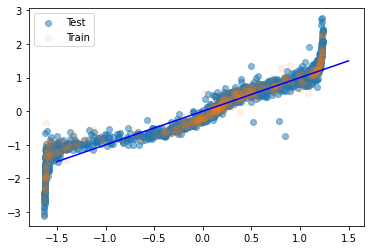

In [103]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 50
hyperparameters["learning_rate"] = 1e-2
hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 64
 
neural_select = "HNN"

H_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters,neural_select)

cpu


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:   0 Training loss: 3.24 Validation loss: 1.19
Epoch:  10 Training loss: 2.31 Validation loss: 0.55
Epoch:  20 Training loss: 1.89 Validation loss: 0.37
root_sqr_error
train error  0.12861448526382446
validation error 0.17138731479644775
test error 0.13142141699790955


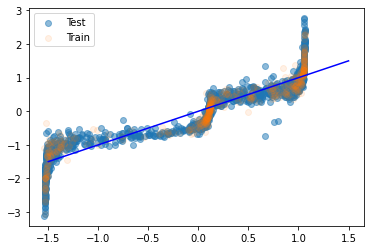

In [113]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 30
hyperparameters["learning_rate"] = 1e-2
hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 64
 
neural_select = "HNN"

H_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters,neural_select)

cpu


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:   0 Training loss: 7.66 Validation loss: 1.41
Epoch:  10 Training loss: 2.94 Validation loss: 0.64
root_sqr_error
train error  0.3388689160346985
validation error 0.4659794867038727
test error 0.3691784739494324


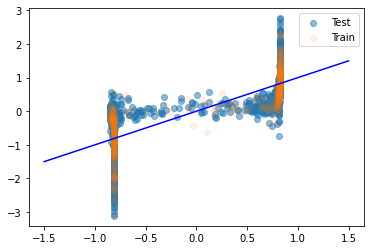

In [114]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 13
hyperparameters["learning_rate"] = 1e-2
hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 64
 
neural_select = "HNN"

H_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters,neural_select)

cpu


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:   0 Training loss: 233.37 Validation loss: 1.31
Epoch:  10 Training loss: 143.46 Validation loss: 0.83
root_sqr_error
train error  0.4847434163093567
validation error 0.7018319964408875
test error 0.5301563143730164


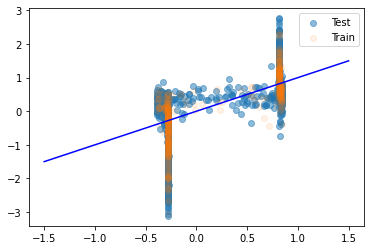

In [116]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 13
hyperparameters["learning_rate"] = 1e-2
hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 256
 
neural_select = "HNN"

H_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters,neural_select)

cpu


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:   0 Training loss: 954.73 Validation loss: 1.18
Epoch:  10 Training loss: 620.09 Validation loss: 0.75
root_sqr_error
train error  0.5067705512046814
validation error 0.6390488147735596
test error 0.5431897044181824


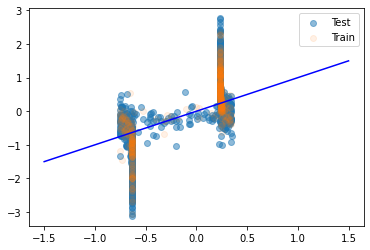

In [117]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 13
hyperparameters["learning_rate"] = 1e-2
hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 512
 
neural_select = "HNN"

H_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters,neural_select)

In [112]:
x = random.sample(range(1,X.shape[0]),1)
print(predict_ground_state(X[int(x[0]),:],"H_model"))
print(y[int(x[0]),:])

-7.154014
[-7.92727529]


## CNN_Result

cpu
Epoch:   0 Training loss: 5.13 Validation loss: 1.16


C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train[:trat_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_validation = torch.tensor(X_validation[:trav_size,:], device=device).float()
C:\Users\junli\AppData\Local\Temp\ipykernel_12804\3220310241.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:trat_size,:], device=d

Epoch:  10 Training loss: 1.60 Validation loss: 0.38
Epoch:  20 Training loss: 1.44 Validation loss: 0.29
Epoch:  30 Training loss: 1.10 Validation loss: 0.21
Epoch:  40 Training loss: 0.73 Validation loss: 0.22
root_sqr_error
train error  0.05092649906873703
validation error 0.0712260752916336
test error 0.05334988981485367


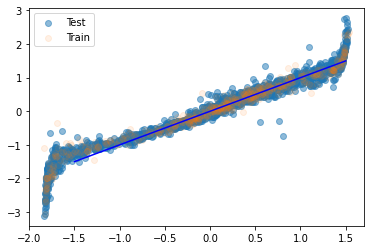

In [118]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 50
hyperparameters["learning_rate"] = 1e-2
hyperparameters["layers_units"] = [X_train.T.shape[0], 100,100, 100, 1]
#hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 64


neural_select = "CNN"
C_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters, neural_select)

In [ ]:
#prev_parameters = copy.deepcopy(hyperparameters)
hyperparameters["training_size"] = 1
hyperparameters["num_epochs"] = 50
hyperparameters["learning_rate"] = 1e-3
hyperparameters["layers_units"] = [X_train.T.shape[0], 1000,1000, 1000, 1]
#hyperparameters["hidden_size"] = 100
hyperparameters["batch_size"] = 64


neural_select = "CNN"
C_model,device = training_model(X_train,X_validation,y_train,y_validation,hyperparameters, neural_select)

In [133]:
x = random.sample(range(1,X.shape[0]),1)
print(predict_ground_state(X[int(x[0]),:],"C_model"))
print(y[int(x[0]),:])

-7.419698
[-7.3388852]


## QNN

In [135]:
'''from torch.optim import LBFGS
from torch import Tensor
model3 = TorchConnector(qnn3, initial_weights)
optimizer = LBFGS(model3.parameters())
f_loss = nn.MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad()#set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)'''

'from torch.optim import LBFGS\nfrom torch import Tensor\nmodel3 = TorchConnector(qnn3, initial_weights)\noptimizer = LBFGS(model3.parameters())\nf_loss = nn.MSELoss(reduction="sum")\n\n# Start training\nmodel3.train()  # set model to training mode\n\n# Define objective function\ndef closure():\n    optimizer.zero_grad()#set_to_none=True)  # Initialize gradient\n    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss\n    loss.backward()  # Backward pass\n    print(loss.item())  # Print loss\n    return loss\n\n\n# Run optimizer\noptimizer.step(closure)'

# Conculsion
## suppost to be look like
I want to run and compare hybrid in difference layer, but got a lot of bugs in the middle.
but I got a double bug when I want to impliment quantum layer to the circuit
In the further I wish this result to more usage for coulomb matrices.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table